In [84]:
from influxdb_client import InfluxDBClient

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import control as ct

In [2]:
client = InfluxDBClient(url='http://kane584.tecnico.ulisboa.pt:8086',
                        token='H1H3MkH8E3L_HUEDJRFLhQuFOyUWR87_bjvgqXda7KzZnzQF3aN4NQs9OrYTJixsqslcyAXsJzP4j41-uRiz4Q==',
                        org='7ffb1a7998038e38')
query_api = client.query_api()

In [3]:
DATE  = '2025-03-13'
START = 'T14:39:00.100'
STOP  = 'T14:40:00'
#output_notebook()
RANGE = f'start:{DATE:s}{START:s}Z, stop:{DATE:s}{STOP:s}Z'
#output_notebook()
query_iflx = (f'from(bucket:"ardu-rasp") |> range({RANGE}) '
    '|> filter(fn: (r) => r._measurement == "imu_data" ) '        
    '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")')
imu_df = query_api.query_data_frame(query=query_iflx)
imu_df.head()

,result,table,_start,_stop,_time,_measurement,device,accel.x,accel.y,accel.z,gyro.z
0,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.484000+00:00,imu_data,ESP32,-0.96,0.29,0.02,2.30
1,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.536000+00:00,imu_data,ESP32,-1.00,0.29,-0.01,-1.67
2,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.589000+00:00,imu_data,ESP32,-1.00,0.30,0.08,2.36
3,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.641000+00:00,imu_data,ESP32,-1.00,0.25,-0.01,1.20
4,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.694000+00:00,imu_data,ESP32,-1.00,0.28,-0.01,-2.22


In [103]:
def select_data(dataframe, date, start_time, end_time):
  t_time = dataframe['_time']
  st = date + ' ' + start_time
  et = date + ' ' + end_time
  mask = (t_time > st) & (t_time <= et)
  return dataframe.loc[mask]

start_time = '14:39:30.300'
end_time = '14:39:35.300'
exp_df = select_data(imu_df, DATE, start_time, end_time)
timeAbs = np.array(exp_df['_time'].astype(np.int64)) / 1.0e9
timeRel = timeAbs - timeAbs[0]

accelX = np.array(exp_df['accel.x'].astype(np.float64))
accelY = np.array(exp_df['accel.y'].astype(np.float64))

gyroZ = np.array(exp_df['gyro.z'].astype(np.float64)) / 180 * np.pi 


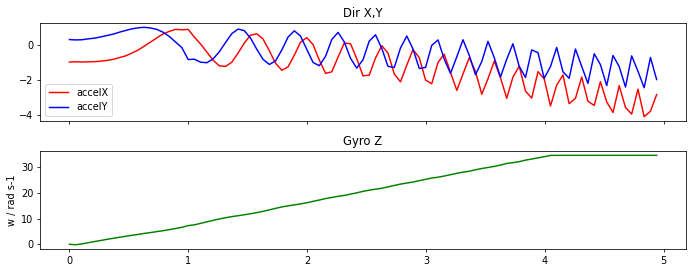

In [104]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 4),  dpi=70)
ax1.plot(timeRel, accelX, color='red', label='accelX') 
ax1.plot(timeRel, accelY, color='blue', label='accelY') 
ax1.legend()
#ax1.set_ylabel()
ax1.set_title('Dir X,Y')
ax2.plot(timeRel, gyroZ, color="green", label='gyroZ') #, line_width=1)
ax2.set_ylabel('w / rad s-1')

ax2.set_title('Gyro Z')
plt.tight_layout()
plt.show()

# State space system
## linear time-invariant (LTI) systems

$$ \frac{dx}{dt} = A x + B u $$
$$ y = C x + D u $$

##  Maxwell Wheel Dynamics
$ x = \begin{bmatrix}
\theta\\
\omega
\end{bmatrix}$, $u = \gamma$  
$ \frac{d\theta}{dt}  = \omega$,  $\frac{d\omega}{dt}  = \gamma$  
$ A = \begin{bmatrix}
0  & 1\\
0 & 0
\end{bmatrix}$, $ B = \begin{bmatrix}
1\\
\gamma
\end{bmatrix}$  

$ C = \begin{bmatrix}
a_x\sin(\theta)  &  0\\
a_y\cos(\theta)  &  0\\
0 & 1 & 
\end{bmatrix}$, $ D = \begin{bmatrix}
0\\
0
\end{bmatrix}$ 

A = [[0. 1.]
     [0. 0.]]

B = [[0.]
     [8.]]

C = [[1. 0.]
     [0. 1.]]

D = [[0.]
     [0.]]


In [111]:
gamma = 8  ## angular accel rad s-2)' 
x = np.array([[0.],     # angle / rad
                [0.]])  # angular velocity (w /rad s-1)
# Define the state transition matrix:
A = np.array([[0.,1.],
                [0.,0.]])
# Input matrix
# B = np.array([[0],
#              [gamma]])
B = np.array([0,
              gamma])
# Output matrix
C = np.array([[1.,0.],  # angle
                [0.,1.]]) # angular velocity
#C = np.array([0,1]) # angular velocity
# Direct feedthrough matrix
#D = np.array([[0.], [0.]])

# Create the state-space model
sys = ct.ss(A, B, C, 0, inputs=['accel'], outputs=['y1', 'y2'])
print(sys)
# Simulate the step response
x0= np.array([np.pi, 0])
T, yout = ct.step_response(sys,  T=np.linspace(0, 5, 100), X0=x0)

<StateSpace>: sys[3]
Inputs (1): ['accel']
Outputs (2): ['y1', 'y2']
States (2): ['x[0]', 'x[1]']

A = [[0. 1.]
     [0. 0.]]

B = [[0.]
     [8.]]

C = [[1. 0.]
     [0. 1.]]

D = [[0.]
     [0.]]



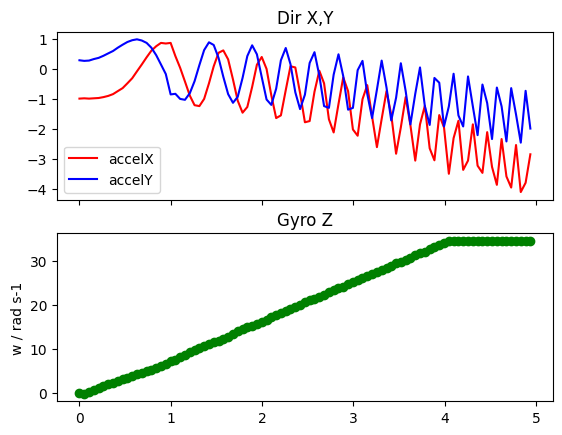

In [112]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(timeRel, accelX, color='red', label='accelX') 
ax1.plot(timeRel, accelY, color='blue', label='accelY') 
ax1.legend()

ax1.set_title('Dir X,Y')
ax2.scatter(timeRel, gyroZ, color="green", label='gyroZ') #, line_width=1)
ax2.set_ylabel('w / rad s-1')

ax2.set_title('Gyro Z')
plt.show()

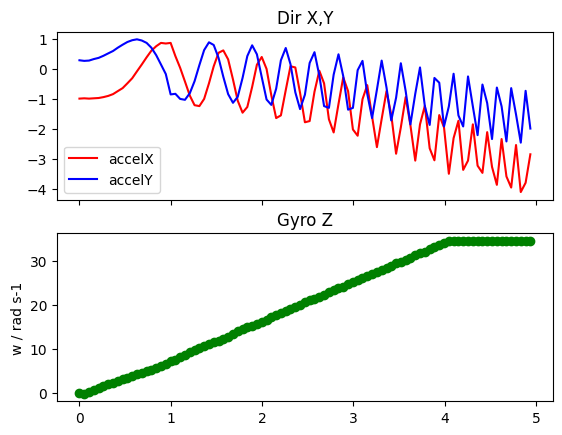

In [113]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(timeRel, accelX, color='red', label='accelX') 
ax1.plot(timeRel, accelY, color='blue', label='accelY') 
ax1.legend()

ax1.set_title('Dir X,Y')
ax2.scatter(timeRel, gyroZ, color="green", label='gyroZ') #, line_width=1)
ax2.set_ylabel('w / rad s-1')

ax2.set_title('Gyro Z')
plt.show()

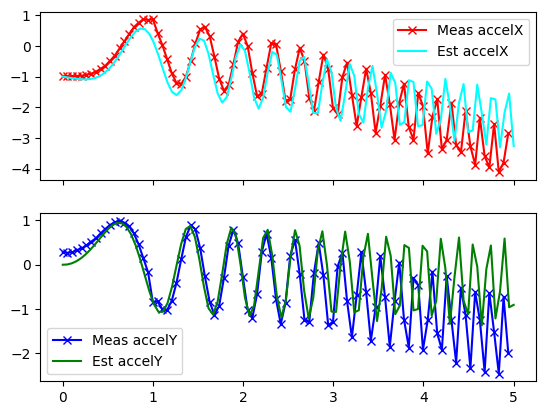

In [114]:

coriolX = -0.06
AestX = np.cos(yout[0][0])  + coriolX * yout[1][0]

coriolY = -0.01
AestY = -np.sin(yout[0][0]) + coriolY * yout[1][0]
GyroZmeas = yout[1][0]
               
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(timeRel, accelX,'-x', color='red', label='Meas accelX') 
ax1.plot(T, AestX,  '-', color='cyan', label='Est accelX') 
ax1.legend()
ax2.plot(timeRel, accelY, '-x',color='b', label='Meas accelY') 
ax2.plot(T, AestY,  '-', color='g', label='Est accelY') 

#ax1.plot(T, AestY, color='blue', label='accelY') 
ax2.legend()
#ax1.set_ylabel()
#ax1.set_title('Dir meas X,Y')
#ax2.plot(T, GyroZmeas, color="green", label='gyroZ') #, line_width=1)
#ax2.set_ylabel('w / rad s-1')

#ax2.set_title('Gyro Z')
plt.show()

In [141]:
# https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html
def imu_model(param, t):
    """
    param[0] - initial angle
    param[1] - angular accel
    param[2] - coriol X
    param[3] - coriol y
    # param[4] - coriol X v**2
    """
    theta = param[0] + 0.5 * param[1] * t**2 # angle 
    v = param[1] * t
    x = np.cos(theta) + param[2] * v  + param[4] * v **2
    y = -np.sin(theta) + param[3] * v

    return np.array([x, y])
    
time = timeRel
imu_meas = np.array([accelX, accelY])
time.shape

(95,)

In [152]:
param0 = [np.pi, 8, 0.01, -0.003, -0.001]
def fun(param):
    return (imu_model(param, time) - imu_meas).flatten()

res = least_squares(fun, param0)
imu_fit = imu_model(res.x, timeRel)
print(f"Angular accel: {res.x[1]:.3f} rad / s^2 ")
res.x

Angular accel: 7.940 rad / s^2 


array([ 3.25052931e+00,  7.94017501e+00,  2.96714967e-03, -3.10652132e-02,
       -2.46326003e-03])

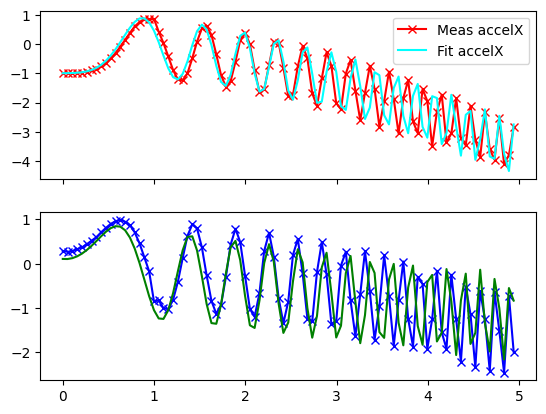

In [153]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(timeRel, accelX,'-x', color='red', label='Meas accelX') 
ax1.plot(timeRel, imu_fit[0],  '-', color='cyan', label='Fit accelX') 
ax1.legend()
ax2.plot(timeRel, accelY, '-x',color='b', label='Meas accelY') 
ax2.plot(timeRel, imu_fit[1],  '-', color='g', label='Est accelY') 
plt.show()

In [121]:
Igz = lambda gamma, m, r, g:  m *  r * ( g / gamma   -  r) 
I_MW = Igz(res.x[1], 0.5158, 2.51e-3, 9.801)
print(f"I_z: {I_MW:.5f} (kg m2)")

I_z: 0.00160 (kg m2)
